In [2]:
%load_ext autoreload

In [10]:
%autoreload

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import jx.funcs as funcs
from gaul import hmc, quap, advi
import pears
import json
import jaxopt
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import geopandas as gpd
import pandas as pd
from jx.spatial import *

# load data, version 1

In [57]:
with (f := open('../data/nyc.json')):
    data = json.load(f)

In [58]:
data = {k: jnp.array(v) for k, v in data.items()}
data['log_E'] = jnp.log(data['E'])

# load data, version 2

In [7]:
data = pd.read_csv('../data/nyc_subset_data.csv')
nyc_shp = gpd.read_file('../data/nycTracts10/nycTracts10.shp')

In [8]:
geoids = nyc_shp['GEOID10'][nyc_shp['GEOID10'].astype(int).isin(data['nyc_tractIDs'])]

In [9]:
nyc_shp_subset = nyc_shp[nyc_shp['GEOID10'].isin(geoids)].sort_values(by=['GEOID10']).reset_index().drop('index', 1)

In [11]:
neighbours_list = geo_to_nb(nyc_shp_subset)

  0%|          | 0/1921 [00:00<?, ?it/s]

In [12]:
node1, node2 = nb_to_graph(neighbours_list)

In [149]:
params = dict(
    beta0 = jnp.zeros(1),
    log_sigma = jnp.zeros(1),
    logit_rho = jnp.ones(1)/2.,
    theta = jnp.zeros(data['N']),
    phi = jnp.ones(data['N']) / data['N'],
)

In [118]:
@jax.jit
def ln_posterior(params, data):
    target = 0.
    
    rho = funcs.stexpit(params['logit_rho'])
    sigma = jnp.exp(params['log_sigma'])
    
    convolved_re = jnp.sqrt(1 - rho) + params['theta'] + jnp.sqrt(rho / data['scaling_factor']) * params['phi']
    
    target += jnp.sum(
        stats.poisson.logpmf(
            data['y'], 
            data['log_E'] + params['beta0'] + convolved_re * sigma
        )
    )

    phidiff = params['phi'][data['node1']] - params['phi'][data['node2']]
    target += -0.5 * jnp.dot(phidiff, phidiff)
    
    target += stats.norm.logpdf(params['beta0'], 0., 1.)
    target += stats.norm.logpdf(params['theta'], 0., 1.).sum()
    target += stats.norm.logpdf(sigma, 0., 1.)
    target += stats.beta.logpdf(rho, 0.5, 0.5)
    target += stats.norm.logpdf(params['phi'].mean(), 0., 0.001)
    
    return target.sum()

nll = lambda p: -ln_posterior(p, data)

In [148]:
losses = []

In [163]:
for i in (pbar := tqdm(range(100))):
    g = jax.grad(nll)(params)
    params = jax.tree_multimap(lambda p, g: p - 1e-6 * g, params, g)
    obj = nll(params).item()
    losses.append(obj)
    if obj < 0:
        break
    if i % 20 == 0:
        pbar.set_description(f"{obj:.2f}")

  0%|                                                                                                                                                                                                                              | 0/100 [00:00<?, ?it/s]


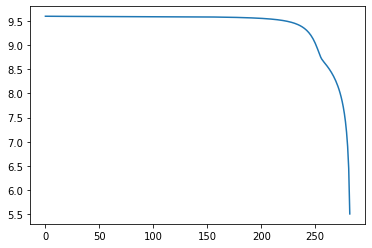

In [172]:
plt.plot(np.log(losses))

In [167]:
log_precision = -2. * params['log_sigma']
logit_rho = params['logit_rho'],
rho = funcs.stexpit(params['logit_rho'])
sigma = jnp.exp(params['log_sigma'])
convolved_re = jnp.sqrt(1 - rho) + params['theta'] + jnp.sqrt(rho / data['scaling_factor']) * params['phi']
eta = data['log_E'] + params['beta0'] + convolved_re + sigma
mu = jnp.exp(eta)

(array([ 28.,   8.,   6.,  11.,  69., 649., 997., 148.,   4.,   1.]),
 array([85.07313 , 86.099266, 87.12541 , 88.15155 , 89.17769 , 90.20383 ,
        91.22997 , 92.25611 , 93.28225 , 94.308395, 95.33453 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

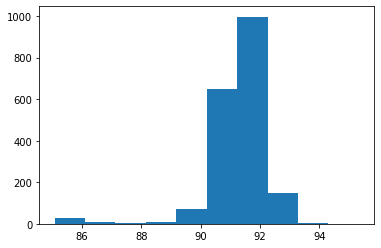

In [168]:
plt.hist(np.array(eta))